# Kuzushiji-MNIST

Kuzushiji-MNIST is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images), provided in the original MNIST format as well as a NumPy format. We are going to use the Hiragana part of the dataset, which is a balanced set of Hiragana characters. Note that each image is 28x28 and there are 49 classes and over 270,000 images in the training set.

[Data source](https://github.com/rois-codh/kmnist)

We are trying to create a model that has a high accuracy and can predict the Hiragana characters. This model will be used inside a web application to help memorize Hiragana characters by drawing them on the screen.  

In [1]:
# import dependencies

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random

## Data Preparation, pre-processing, and augmentation

In [2]:
# import data

images_data = np.load("data/k49-train-imgs.npz")
train_images = images_data["arr_0"]

labels_data = np.load("data/k49-train-labels.npz")
train_labels = labels_data["arr_0"]

print(train_images.shape)
print(train_labels.shape)

image_index = 0
image = train_images[image_index]
label = train_labels[image_index]

(232365, 28, 28)
(232365,)


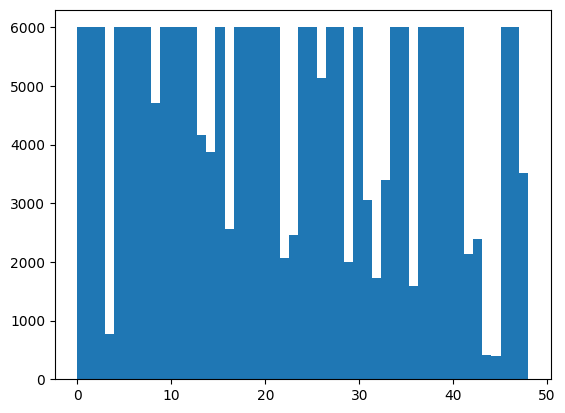

In [19]:
# show label amount using histogram

plt.hist(train_labels, bins=49)
plt.show()

Looking at this data we can see that there is a bit of a class imbalance.We will need to do some data augmentation to help with the class imbalance.

In [3]:
# data preprocessing

test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=test_size, random_state=random_state
)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (185892, 28, 28, 1)
Train labels shape: (185892,)
Test images shape: (46473, 28, 28, 1)
Test labels shape: (46473,)


In [17]:
# create an ImageDataGenerator for data augmentation

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

## Model Creation

In [18]:
# create a model

images_classes = 49

model = Sequential()

model.add(Flatten(input_shape=(28,28)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(images_classes, activation='softmax'))

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

fitted_model = model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    validation_data=(X_test, y_test),
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
1453/1453 [==============================] - 46s 30ms/step - loss: 1.9505 - accuracy: 0.4704 - val_loss: 0.8815 - val_accuracy: 0.7548
Epoch 2/200
1453/1453 [==============================] - 45s 31ms/step - loss: 1.3774 - accuracy: 0.6196 - val_loss: 0.7105 - val_accuracy: 0.7977
Epoch 3/200
1453/1453 [==============================] - 50s 34ms/step - loss: 1.2204 - accuracy: 0.6616 - val_loss: 0.6153 - val_accuracy: 0.8271
Epoch 4/200
1453/1453 [==============================] - 50s 34ms/step - loss: 1.1388 - accuracy: 0.6848 - val_loss: 0.5517 - val_accuracy: 0.8427
Epoch 5/200
1453/1453 [==============================] - 48s 33ms/step - loss: 1.0783 - accuracy: 0.7002 - val_loss: 0.5201 - val_accuracy: 0.8535
Epoch 6/200
1453/1453 [==============================] - 46s 32ms/step - loss: 1.0388 - accuracy: 0.7121 - val_loss: 0.4843 - val_accuracy: 0.8616
Epoch 7/200
1453/1453 [==============================] - 49s 34ms/step - loss: 1.0044 - accuracy: 0.7226 - val_loss: 0

In [19]:
# save model

model.save("model/k49_model.h5")

c:\Users\denis\.virtualenvs\handwriting-japan-y1vdMaZ6\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [4]:
# load model and show summary

loaded_model = load_model('model/k49_model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)              

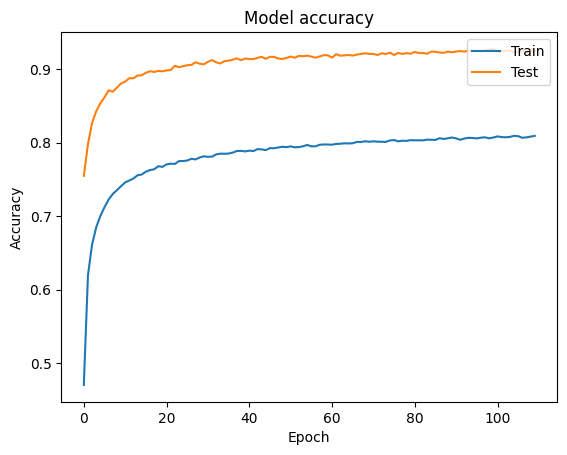

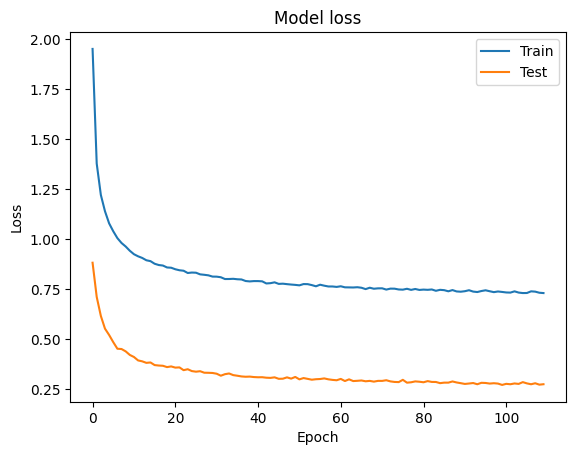

In [24]:
# Plot training & validation accuracy values

plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation loss values

plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [25]:
# evaluating the model

loss, accuracy = model.evaluate(X_test, y_test)
print(f"loss: {str(loss)}\n accuracy: {str(accuracy)}")

1453/1453 [==============================] - 5s 3ms/step - loss: 0.2739 - accuracy: 0.9249
loss: 0.2739102840423584
 accuracy: 0.9248595833778381


1/1 [==============================] - 0s 19ms/step


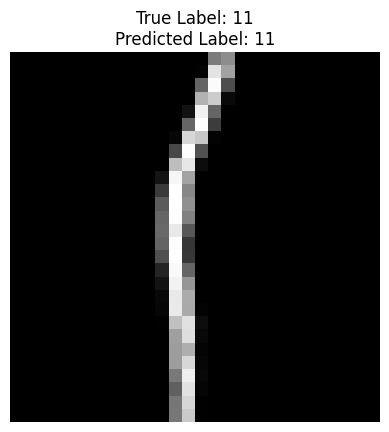

1/1 [==============================] - 0s 24ms/step


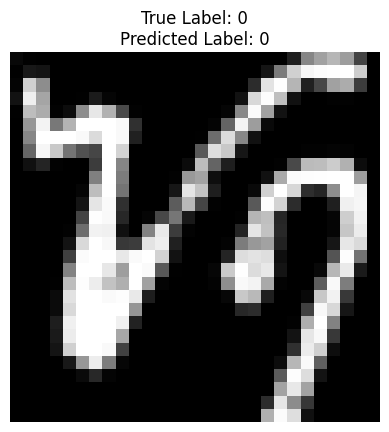

1/1 [==============================] - 0s 24ms/step


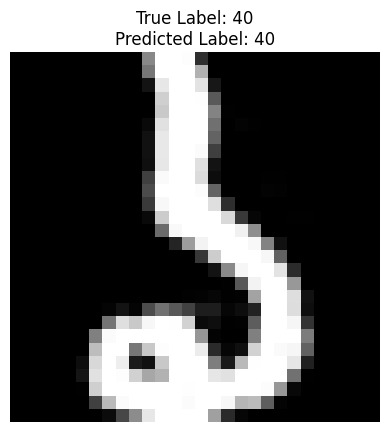

1/1 [==============================] - 0s 20ms/step


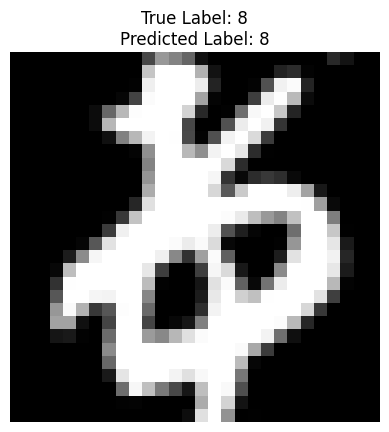

1/1 [==============================] - 0s 26ms/step


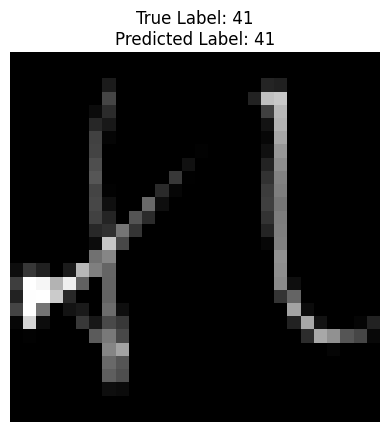

1/1 [==============================] - 0s 18ms/step


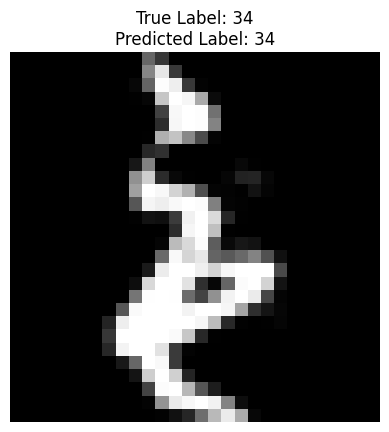

1/1 [==============================] - 0s 30ms/step


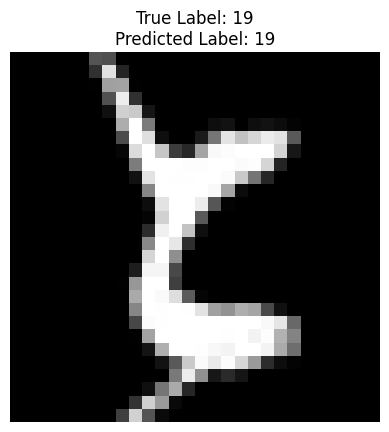

1/1 [==============================] - 0s 21ms/step


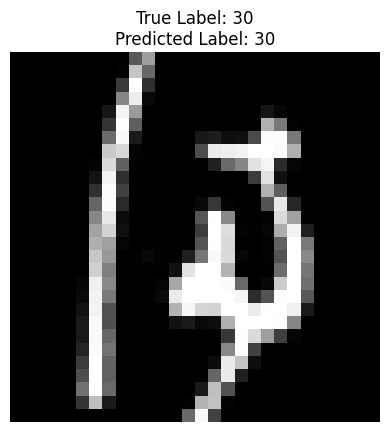

1/1 [==============================] - 0s 22ms/step


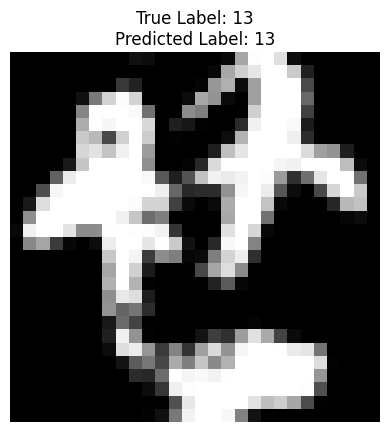

1/1 [==============================] - 0s 20ms/step


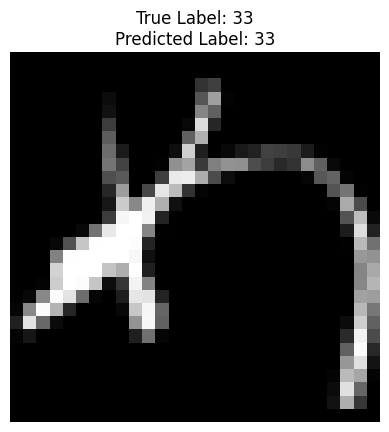

In [15]:
# predict on test data and show the results

images_data = np.load("data/k49-test-imgs.npz")
test_images = images_data["arr_0"]

labels_data = np.load("data/k49-test-labels.npz")
test_labels = labels_data["arr_0"]

random_indices = random.sample(range(len(test_images)), 10)

for image_index in random_indices:
    test_image = test_images[image_index]
    true_label = test_labels[image_index]

    input_image = test_image.reshape(1, 28, 28, 1).astype('float32') / 255.0

    predicted_probs = loaded_model.predict(input_image)
    predicted_label = np.argmax(predicted_probs)

    plt.imshow(test_image, cmap='gray')
    plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()


Looking at these random images taken from the test set, we can see that the model is able to predict the correct class for most of the images. However, it does seem to struggle with some of the images, especially those that are quite ambiguous. In this example it got 10/10 right, giving it an accuracy of 100% (the test accuracy is around 92% and we only used 10 images for this self test).

The model has already been saved in the path `model/k49_model.h5`. This model will be used in the application.

The file `k49_classmap.csv` contains the mapping from class index to Hiragana character. This will be used to display the predicted character in the application. You can also use it for yourself to see what the model is predicting.